In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
df_train = pd.read_csv('titanic_train.csv')
df_test = pd.read_csv('titanic_test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


A "Survived" feature with NaN values was added in df_test just for Pandas being able to concatenate the two dataframes.

In [5]:
df_test['Survived'] = np.NaN

In [6]:
df = pd.concat([df_train,df_test],axis=0,ignore_index=True)
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


The first thing we have to do is to fill the null and the NaN values in all the features will be useful for the model.

In [8]:
def clean_nan_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return df['Age'][df['Pclass']==Pclass].mean()
        if Pclass == 2:
            return df['Age'][df['Pclass']==Pclass].mean()
        if Pclass == 3:
            return df['Age'][df['Pclass']==Pclass].mean()
    else:
        return Age
    
df['Age'] = df[['Age','Pclass']].apply(clean_nan_age,axis=1) 

In [9]:
df['Embarked'].fillna(df['Embarked'].value_counts().idxmax(),inplace=True)

In [10]:
df['Fare'].fillna(df['Fare'].fillna(df['Fare'][df['Pclass']==3].mean()),inplace=True)

Some non-numeric features in the dataset can be written in a numeric binary form so we can take more data for the model and better results as of. This is going to be done with 'get_dummies' and then concatenate them with the original data.

In [11]:
df_emb = pd.get_dummies(df['Embarked'],columns='Embarked',prefix='Embarked')
df = pd.concat([df.drop('Embarked',axis=1),df_emb],axis=1)

In [12]:
df_sex = pd.get_dummies(df['Sex'],columns='Sex',prefix='Sex')
df = pd.concat([df.drop('Sex',axis=1),df_sex],axis=1)

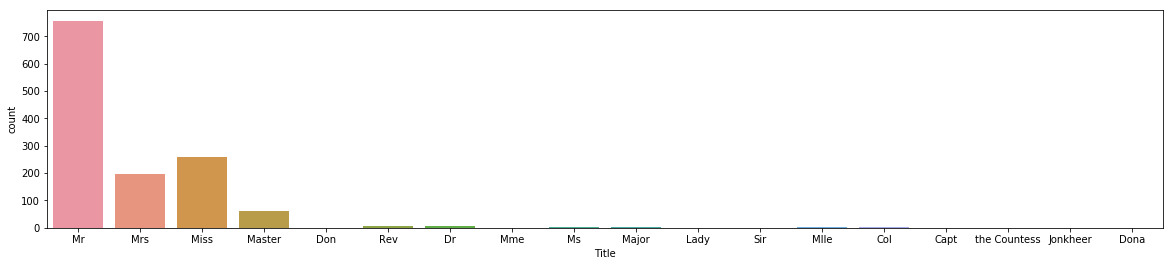

In [13]:
df['Title'] = df['Name'].apply(lambda name:name.split(', ')[1].split('.')[0])
plt.figure(figsize=(20,4))
sns.countplot(x='Title',data=df)

In [14]:
df_title = pd.get_dummies(df['Title'],columns='Title',prefix='Title')
df = pd.concat([df.drop('Title',axis=1),df_title],axis=1)

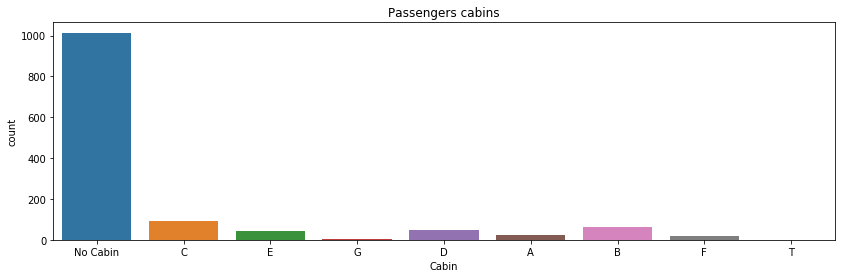

In [15]:
df['Cabin'] = df['Cabin'][df['Cabin'].notnull()].apply(lambda cabin:cabin[0])
df['Cabin'] = df['Cabin'].fillna('No Cabin')
plt.figure(figsize=(14,4))
plt.title('Passengers cabins')
sns.countplot(x='Cabin',data=df)

In [16]:
df_cabin = pd.get_dummies(df['Cabin'],columns='Cabin',prefix='Cabin')
df = pd.concat([df.drop('Cabin',axis=1),df_cabin],axis=1)

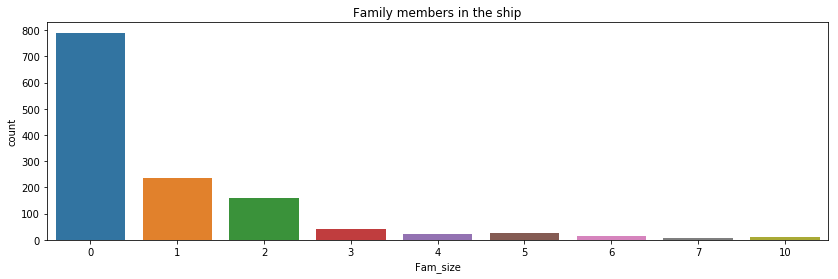

In [17]:
df['Fam_size'] = df['Parch'] + df['SibSp']
plt.figure(figsize=(14,4))
plt.title('Family members in the ship')
sns.countplot(x='Fam_size',data=df)

df['Alone'] = df['Fam_size'].apply(lambda size:1 if size==0 else 0)
df['Small_Fam'] = df['Fam_size'].apply(lambda size:1 if size<2 else 0)
df['Medium_Fam'] = df['Fam_size'].apply(lambda size:1 if size>2 & size<5 else 0)
df['Big_Fam'] = df['Fam_size'].apply(lambda size:1 if size>5 else 0)

In [18]:
df_pclass = pd.get_dummies(df['Pclass'],columns='Pclass',prefix='Pclass')
df = pd.concat([df.drop('Pclass',axis=1),df_pclass],axis=1)

Some useful visualizations will follow in order to understand better the data.

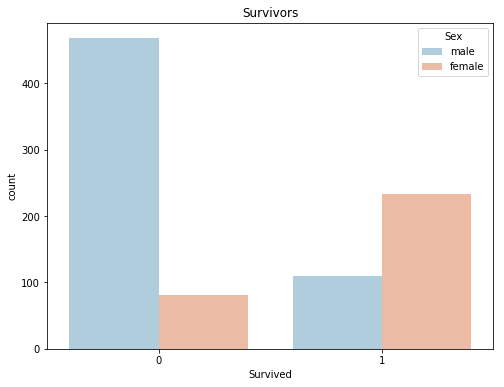

In [19]:
plt.figure(figsize=(8,6))
plt.title('Survivors')
sns.countplot(data=df_train,x='Survived',hue='Sex',palette='RdBu_r')

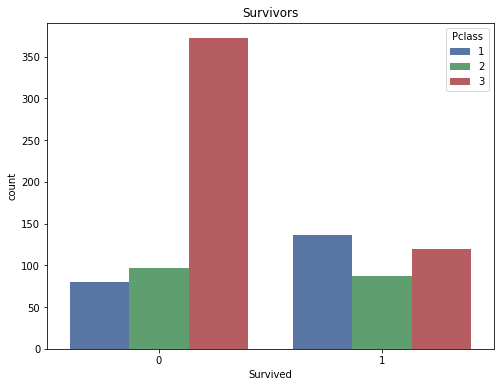

In [20]:
plt.figure(figsize=(8,6))
plt.title('Survivors')
sns.countplot(data=df_train,x='Survived',hue='Pclass',palette='deep')

A lot of passengers of the third class did not survive. This may happened due to the lowest safety the may had.

The final form of the dataset.

In [21]:
df.head()

,Age,Fare,Name,Parch,PassengerId,SibSp,Survived,Ticket,Embarked_C,Embarked_Q,...,Cabin_No Cabin,Cabin_T,Fam_size,Alone,Small_Fam,Medium_Fam,Big_Fam,Pclass_1,Pclass_2,Pclass_3
0,22.0,7.2500,"Braund, Mr. Owen Harris",0,1,1,0.0,A/5 21171,0,0,...,1,0,1,0,1,1,0,0,0,1
1,38.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1.0,PC 17599,1,0,...,0,0,1,0,1,1,0,1,0,0
2,26.0,7.9250,"Heikkinen, Miss. Laina",0,3,0,1.0,STON/O2. 3101282,0,0,...,1,0,0,1,1,0,0,0,0,1
3,35.0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1.0,113803,0,0,...,0,0,1,0,1,1,0,1,0,0
4,35.0,8.0500,"Allen, Mr. William Henry",0,5,0,0.0,373450,0,0,...,1,0,0,1,1,0,0,0,0,1


Now we are ready to split our data into training and testing sets, see the score, and get some predictions.

In [22]:
X_train = df.iloc[0:len(df_train)].drop(['Name','PassengerId','Ticket','Survived'],axis=1)
y_train = df.iloc[0:len(df_train)]['Survived']
X_test = df.iloc[len(df_train):len(df)].drop(['Name','PassengerId','Ticket','Survived'],axis=1)

rfc = RandomForestClassifier(n_estimators=100,min_samples_leaf=50)
rfc.fit(X_train, y_train)
y_pred=rfc.predict(X_test).astype(int)
print('Score: ',rfc.score(X_train,y_train))

Score:  0.7867564534231201


A score like this is not that bad but it can get better by optimizing the parameters of rfc. (and this takes time, long time...)

In [23]:
rfc_param_grid = {"max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 25, 50],
              "n_estimators" :[100,300]}
rfc_grid_search = GridSearchCV(rfc,param_grid = rfc_param_grid, scoring="accuracy", n_jobs= 4, verbose = 1)
rfc_grid_search.fit(X_train,y_train)

rfc_grid_search_best = rfc_grid_search.best_estimator_

y_pred=rfc_grid_search_best.predict(X_test).astype(int)
print(rfc_grid_search.best_score_)

res = pd.DataFrame(data = y_pred, index = np.arange(892,892+len(y_pred)), columns = ['Survived'])
res.index.name = 'PassengerId'
res.to_csv('results.csv')
print('Done!')

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 162 out of 162 | elapsed:  3.3min finished


0.8316498316498316
Done!


Better results can be obtained by taking more informations about the data and of course forming them in a way that the model can process them.